In [47]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

In [48]:
def spell_calc(fight_settings,buffs,talents,stats):
    haste = 1+stats['haste']/1577.
    
    #{rank:(damage,coeff,mana,time), ...}
    spells = {
        'moonfire':(
            {'coeff':0.15,'coeffD':0.52,'time':max(1,1.5/haste),
             'duration':15+3*buffs['T6 2pc'],
             'crit':stats['crit']+0.05*talents['Improved Moonfire']},
            {'base':(9+12)/2.,'DoT':12,'level':4,'mana':25},
            {'base':(17+21)/2.,'DoT':32,'level':10,'mana':50},
            {'base':(30+37)/2.,'DoT':52,'level':16,'mana':75},
            {'base':(47+55)/2,'DoT':80,'level':22,'mana':105},
            {'base':(70+82)/2.,'DoT':124,'level':28,'mana':150},
            {'base':(91+108)/2.,'DoT':164,'level':34,'mana':190},
            {'base':(117+137)/2.,'DoT':212,'level':40,'mana':235},
            {'base':(143+168)/2.,'DoT':264,'level':46,'mana':280},
            {'base':(172+200)/2.,'DoT':320,'level':52,'mana':325},
            {'base':(205+238)/2.,'DoT':384,'level':58,'mana':375},
            {'base':(238+276)/2.,'DoT':444,'level':63,'mana':430},
            {'base':(305+357)/2.,'DoT':600,'level':70,'mana':495}
        ),
        'starfire':(
            {'coeff':1+0.04*talents['Wrath of Cenarius'],
             'time':max(1,(3.5-0.1*talents['Starlight Wrath'])/haste),
             'crit':stats['crit']+0.02*talents['Focused Starlight']+0.05*buffs['T6 4pc']},
            {'base':(95+115)/2.,'level':20,'mana':95},
            {'base':(146+177)/2.,'level':26,'mana':135},
            {'base':(212+253)/2.,'level':34,'mana':180},
            {'base':(293+348)/2,'level':42,'mana':230},
            {'base':(378+445)/2.,'level':50,'mana':275},
            {'base':(463+543)/2.,'level':58,'mana':315},
            {'base':(514+603)/2.,'level':60,'mana':340},
            {'base':(550+647)/2.,'level':67,'mana':370}
        ),
        'wrath':(
            {'coeff':1.5/3.5+0.02*talents['Wrath of Cenarius'],
             'time':max(1,(2-0.1*talents['Starlight Wrath'])/haste),
             'crit':stats['crit']+0.02*talents['Focused Starlight']},
            {'base':(13+16)/2.,'level':1,'mana':20},
            {'base':(28+33)/2.,'level':6,'mana':35},
            {'base':(48+57)/2.,'level':14,'mana':55},
            {'base':(69+79)/2.,'level':22,'mana':70},
            {'base':(108+123)/2.,'level':30,'mana':100},
            {'base':(143+167)/2.,'level':38,'mana':125},
            {'base':(198+221)/2.,'level':46,'mana':155},
            {'base':(248+277)/2.,'level':54,'mana':180},
            {'base':(292+327)/2.,'level':61,'mana':210},
            {'base':(383+432)/2.,'level':69,'mana':255}
        ),
        'insect swarm':(
            {'coeff':0.76, 'time':max(1,1.5/haste),'duration':15},
            {'DoT':108,'level':20,'mana':50},
            {'DoT':192,'level':30,'mana':85},
            {'DoT':300,'level':40,'mana':110},
            {'DoT':432,'level':50,'mana':135},
            {'DoT':594,'level':60,'mana':155},
            {'DoT':792,'level':70,'mana':175},
        ),
        'faerie fire':{'time':max(1,1.5/haste)*fight_settings['faerie fire'],'duration':40.,'mana':145},
        'innervate':{'time':max(1,1.5/haste)*fight_settings['innervate'],'duration':480.-48*buffs['T4 4pc'],'mana':84}
    }
    
    for name in spells:
        if name not in ['faerie fire','innervate']:
            for rank in spells[name][1:]:
                spell = spells[name]
                if name in ['moonfire','starfire','wrath']:
                    rank['mana'] = int(rank['mana']*(1-0.03*talents['Moonglow']))
                rank['time'] = spell[0]['time']
                if spell[0].has_key('duration'):
                    rank['duration'] = spell[0]['duration']
                if rank['level'] <= 20:
                    penalty = 1-((20-rank['level'])*0.0375) 
                else:
                    penalty = 1
                penalty *= min(1,(rank['level']+11)/70.)
                rank['coeff'] = spell[0]['coeff']*penalty
                if spell[0].has_key('coeffD'):
                    rank['coeffD'] = spell[0]['coeffD']*penalty
            
    return spells

In [49]:
def settings(T,variation=(0,0,0,0,0,0,0,0,0)):
    #editable settings
    buffs = {
        'elements':True,
        'malediction':True,
        'misery':True,
        'T4 2pc':False,
        'T4 4pc':False,
        'T5 4pc':False,
        'T6 2pc':False,
        'T6 4pc':False,
        'CSD':False,
        'vamp embrace':False,
        'spriestDPS':750,
        'tide':False,
        'spring':True,
        'imp spring':True,
        'JoW':True,
        'IDS':False,
        'spellfire':False,
        'totem of wrath':False,
        'wrath of air':False,
        'ele T4 2pc':False,
        'SF idol':False,
        'W idol':False,
        'draenei':False,
        'stormstrike uptime':0
    }
    talents = {
        'Starlight Wrath':5,
        'Focused Starlight':2,
        'Improved Moonfire':2,
        'Vengeance':5,
        'Lunar Guidance':3,
        "Nature's Grace":1,
        'Moonglow':3,
        'Balance of Power':2,
        'Moonfury':5,
        'Dreamstate':3,
        'Wrath of Cenarius':5,
        'Force of Nature':1,
        'Naturalist':5,
        'Intensity':3
    }
    stats = {
        'base mana':2090,
        'hit':0.115,
        'crit':0.25,
        'int':400,
        'spi':250,
        'Mp5':50,
        'haste':0,
        'arcane':1000,
        'nature':1000
    }
    fight_settings = {
        'faerie fire':True,
        'fight length':T,
        'mana pot':True,
        'dark rune':True,
        'nLust':0,
        'nPI':0,
        'innervate':True
    }
    
    #stats calculation
    stats['hit'] = min(stats['hit']+0.02*talents['Balance of Power']+0.03*buffs['totem of wrath']+
                     variation[1]/1262.5+0.01*buffs['draenei'],0.16)
    stats['crit'] = min(stats['crit']+0.03*buffs['totem of wrath']+
                      variation[2]/2208.+stats['int']/80./100,1)
    stats['int'] += variation[3]; stats['spi'] += variation[4]
    stats['Mp5'] += variation[5]; stats['haste'] += variation[6]
    spellpower_mod = (stats['int']*(0.25*talents['Lunar Guidance']/3+0.07*buffs['spellfire'])+
                      (101+20*buffs['ele T4 2pc'])*buffs['wrath of air']+stats['spi']*0.1*buffs['IDS'])
    stats['arcane'] += spellpower_mod+variation[7]+variation[0]
    stats['nature'] += spellpower_mod+variation[8]+variation[0]
    
    return (fight_settings,buffs,talents,stats,spell_calc(fight_settings,buffs,talents,stats))

In [50]:
def encounter(encounter_settings,burn_rot=['MF','SF'],burn_ranks=[12,8],
              regen_rot=['SF'],regen_ranks=[1],details=False,print_out=False):
    
    fight_settings,buffs,talents,stats,spells = encounter_settings
    T = fight_settings['fight length']
    
    #calculations
    E = 1+(0.1+0.03*buffs['malediction'])*buffs['elements'] # curse of elements effect
    W = 1+0.05*buffs['misery'] # misery effect
    hit_chance = 0.83+stats['hit'] # chance to hit
    crit_mod = (1.5*(1+0.03*buffs['CSD'])-1)*(1+0.2*talents['Vengeance'])
    partial = 0.94 # average mitigation from partial resists
    arc_mod = E*W*hit_chance*partial # arcane damage modifier
    nat_mod = W*hit_chance*partial*(1+0.2*buffs['stormstrike uptime']) # nature damage modifier
    M0 = stats['base mana']+15*stats['int'] # initial mana pool
    nInner = ((T-20)/(480.-48*buffs['T4 4pc'])+0.5)*fight_settings['innervate'] # number of innervates per fight
    nTide = ((T-12)/300.+0.5)*buffs['tide'] # number of mana tides per fight
    mPot = (1800+3000)/2.*fight_settings['mana pot']; mRune = (900+1500)/2.*fight_settings['dark rune']
    Mt = (
        stats['Mp5']/5.+
        0.1*talents['Intensity']*(0.001+stats['spi']*np.sqrt(stats['int'])*0.009327)+ # spirit based regen
        0.1*stats['int']/5*talents['Dreamstate']/3.+
        (mPot+mRune)/120.+
        0.24*nTide*M0/T+ # mana tide totem
        (5-0.1*talents['Intensity'])*(0.001+stats['spi']*np.sqrt(stats['int'])*0.009327)*nInner*20/T+ # innervate mana gain
        buffs['spring']*20*(1+0.25*buffs['imp spring'])/2.+ # mana spring totem
        buffs['spriestDPS']*0.05*buffs['vamp embrace'] # shadow priest mana regen
    )
    
    innervate = spells['innervate']
    faerie_fire = spells['faerie fire']
    Tin = innervate['time']*fight_settings['innervate']
    Tind = innervate['duration']
    Min = innervate['mana']*fight_settings['innervate']
    Tff = faerie_fire['time']*fight_settings['faerie fire']
    Tffd = faerie_fire['duration']
    Mff = faerie_fire['mana']*fight_settings['faerie fire']
    cm = spells['moonfire'][0]['crit']
    cs = spells['starfire'][0]['crit']
    cw = spells['wrath'][0]['crit']
    
    def parse_rotation(rotation,ranks):
        moonfire_names = {'MF','moonfire','Moonfire'}
        starfire_names = {'SF','starfire','Starfire'}
        wrath_names = {'W','wrath','Wrath'}
        insectswarm_names = {'IS','insect swarm','insectswarm','InsectSwarm','Insect Swarm'}
        dots = []
        for n,spell in enumerate(rotation):
            if spell in moonfire_names:
                dots.append(('moonfire',ranks[n]))
            elif spell in starfire_names:
                filler = ('starfire',ranks[n])
            elif spell in wrath_names:
                filler = ('wrath',ranks[n])
            elif spell in insectswarm_names:
                dots.append(('insect swarm',ranks[n]))
        return dots,filler
    
    def sim(dots,filler):
        NG = bool(talents["Nature's Grace"])
        for n,dot in enumerate(dots):
            if 'moonfire' in dot[0]:
                MF = spells['moonfire'][dots[n][1]]
                Tm = MF['time']
                Tmd = MF['duration']
                Mm = MF['mana']
                Dm = (((MF['base']+MF['coeff']*stats['arcane'])*(1+crit_mod*cm)+
                       (MF['DoT']+MF['coeffD']*stats['arcane']))*(1+buffs['T6 2pc']/4.)*
                      arc_mod*(1+0.05*talents['Improved Moonfire'])*(1+0.02*talents['Moonfury']))
            else:
                Tm,Tmd,Dm,Mm = 0,12,0,0
            if 'insect swarm' in dot[0]:
                IS = spells['insect swarm'][dots[n][1]]
                Ti = IS['time']
                Tid = IS['duration']
                Mi = IS['mana']
                Di = (IS['DoT']+IS['coeff']*stats['nature'])*nat_mod
            else:
                Ti,Tid,Di,Mi = 0,1,0,0
        if filler[0] == 'starfire':
            SF = spells['starfire'][filler[1]]
            Tf = SF['time']
            cf = cs
            Mfill = SF['mana']
            Df = ((SF['base']+SF['coeff']*(stats['arcane']+55*buffs['SF idol']))*
                  (1+crit_mod*cs)*arc_mod*(1+0.02*talents['Moonfury']))
        elif filler[0] == 'wrath':
            W = spells['wrath'][filler[1]]
            Tf = W['time']
            NG = False # NG does not do anything for talented wrath because GCD
            cf = cw
            Mfill = W['mana']
            Df = ((W['base']+W['coeff']*(stats['nature']+25*buffs['W idol']))*
                  (1+crit_mod*cw)*nat_mod*(1+0.02*talents['Moonfury']))
            
        JoW = (74*0.5*buffs['JoW']+120*0.25*buffs['T4 2pc'])*hit_chance # mana return from  a spell hit
        if not dots: # no dots in rotation
            Trot = Tf-0.5*cf*hit_chance*NG
            Drot = Df
            Mrot = Mfill-JoW
        else:
            # average number of fillers within one dot duration
            if NG and Tm != 0:
                n = (cf*hit_chance*(hit_chance*cm+1)+2*(Tm+Ti*Tmd/Tid)-hit_chance*cm-2*Tmd)/(cf*hit_chance-2*Tf)
            else:
                n = (max(Tmd,Tid)-(Tm+Ti*Tmd/Tid))/(Tf-0.5*cf*hit_chance*NG)
            Trot = max(Tmd,Tid)
            Drot = n*Df+Dm+Tmd/Tid*Di
            Mrot = (n*Mfill+Mm+Tmd/Tid*Mi)-JoW*(n+len(dots))
        
        Mrot += Trot*(Mff/Tffd+Min/Tind)
        Trot *= 1+Tff/Tffd+Tin/Tind
        Tp = M0/abs(Mrot/Trot-Mt) # time of whole phase
        DPS = Drot/Trot
        return DPS,Tp

    burn_dots,burn_filler = parse_rotation(burn_rot,burn_ranks)
    regen_dots,regen_filler = parse_rotation(regen_rot,regen_ranks)
    Bdps,Tb = sim(burn_dots,burn_filler) # burn DPS and phase length
    Rdps,Tr = sim(regen_dots,regen_filler) # regen DPS and phase length
    Tb = min(Tb,T) # cut burn phase if too long
    nr = max(0,math.floor((T-Tb)/(Tb+Tr))); nb=nr+1 # number of burn and regen phases
    Te = max(0,T-Tb*nb-Tr*nr) # length of the final mini burn+regen phase
    Db = Bdps*Tb; Dr = Rdps*Tr; De=(Db+Dr)*Te/(Tb+Tr) # total damage done in each single phase
    D = Db*nb+Dr*nr+De; Dps = D/T # total damage done over entire fight, and DPS for the fight
    if details and print_out:
        print("DPS={}, Tb={}, Bdps={}, Tr={}, Rdps={}, Te={}, Edps={}".format(Dps,Tb,Bdps,Tr,Rdps,Te,De/Te))
    elif print_out:
        print("DPS={}".format(Dps))
    else:
        return Dps

In [51]:
def get_stat_weights(rotation,fight_data=(10,600)):
    burn_rot,burn_ranks,regen_rot,regen_ranks = rotation
    min_length,max_length = fight_data
    DPS_weights = np.zeros((9,max_length-min_length+1))
    SP_weights = np.zeros((8,max_length-min_length+1))
    for T in range(min_length,max_length+1):
        variations = [0,0,0,0,0,0,0,0,0]
        default=encounter(settings(T,variations),burn_rot,burn_ranks,regen_rot,regen_ranks)
        for v in range(0,9):
            variations[v]=1
            dps_change = encounter(settings(T,variations),burn_rot,burn_ranks,regen_rot,regen_ranks)-default
            DPS_weights[v,T-min_length] = dps_change
            if v==0:
                normalizer = dps_change
            else:
                SP_weights[v-1,T-min_length]=dps_change/normalizer
            variations[v]=0
    return SP_weights,DPS_weights

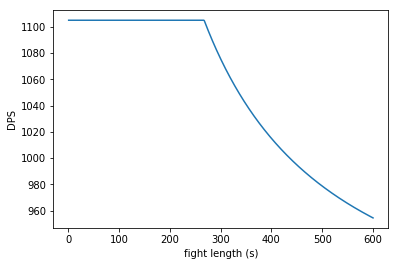

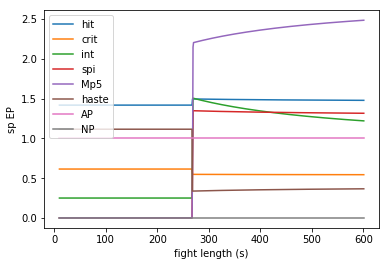

hit 1.4188331535143734 1.4858601850631312
crit 0.6147200420776746 0.5452947496185049
int 0.25000000000017386 1.3362871153764029
spi 0.0 1.329268349278839
Mp5 0.0 2.3716899141956205
haste 1.1157242621466548 0.3546384220112376
AP 1.0 1.0
NP 0.0 0.0


In [52]:
rotation = (['MF','SF'],[-1,-1],['SF'],[1])

lengths=np.linspace(1,600,600)
for burn_rot in ['MFSF']:
    for regen_rot in ['SF']:
        dpss=[]
        for fight_length in lengths:
            dpss.append(encounter(settings(fight_length),['MF','SF'],[-1,-1],['SF'],[1]))
        plt.plot(lengths,dpss,label=burn_rot+' '+regen_rot)
plt.xlabel('fight length (s)')
plt.ylabel('DPS')
plt.show()

SP_weights,DPS_weights=get_stat_weights(rotation)
stats=['hit','crit','int','spi','Mp5','haste','AP','NP']
for n in range(0,8):
    plt.plot(np.linspace(10,601,591),SP_weights[n,:],label=stats[n])
plt.xlabel('fight length (s)')
plt.ylabel('sp EP')
plt.legend()
plt.show()
for n,stat in enumerate(stats):
    print stat,SP_weights[n,90],SP_weights[n,400]